# Multimodal

In [49]:
import pickle
import importlib
import utils
import models
importlib.reload(utils)
from utils import *
importlib.reload(models)
from models import *
from torch.utils.data import DataLoader, Subset
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Function to load a memmap file
def load_memmap(filename, dtype, shape):
    # Load the memmap file with read-only mode
    return np.memmap(filename, dtype=dtype, mode='r', shape=shape)

# Assuming you know the dtype and shape, for example:
# For trainX_sequences
dtype_trainX_sequences = np.int64  # or the correct dtype for your data
shape_trainX_sequences = (3038976, 16)  # replace with the correct shape
trainX_sequences = load_memmap('./../data/jan-march/trainX_sequences.memmap', dtype_trainX_sequences, shape_trainX_sequences)

# For trainX
dtype_trainX = np.int64  # or the correct dtype for your data
shape_trainX = (3038976, 12, 8, 8)  # replace with the correct shape
trainX_boards = load_memmap('./../data/jan-march/trainX.memmap', dtype_trainX, shape_trainX)

# For trainY
dtype_trainY = np.int64  # or the correct dtype for your data
shape_trainY = (3038976,)  # replace with the correct shape
trainY = load_memmap('./../data/jan-march/trainY.memmap', dtype_trainY, shape_trainY)

# For trainX_seqlengths
dtype_trainX_seqlengths = np.int64  # or the correct dtype for your data
shape_trainX_seqlengths = (3038976,)  # replace with the correct shape
trainX_seqlengths = load_memmap('./../data/jan-march/trainX_seqlengths.memmap', dtype_trainX_seqlengths, shape_trainX_seqlengths)

with open('./../data/jan-march/vocab.pkl', 'rb') as inp:
    vocab = pickle.load(inp)

Now that we have our raw data, we need to be able to make sense of chess moves. Meaning, we're transforming our entire world from chess moves into numerical tokens that will serve as indices into unique embeddings

In [4]:
# We can just use nn.Embedding later when we pass the model a sequence of indices, but this is if we ever want to pre-train and have access to the matrix we've trained
def get_embedding_matrix(vocab, d_embed):
    n_embed = len(vocab.move_to_id)
    return np.random.normal(0, 1, (n_embed, d_embed))
# embedding_matrix = get_embedding_matrix(vocab, 64)
    

In [3]:
print(len(vocab.id_to_move.keys()))
print(torch.tensor(trainX_boards[0]).shape)
print(trainX_boards[0])

8121
torch.Size([12, 8, 8])
[[[0 0 0 0 0 0 0 0]
  [1 1 0 0 1 0 1 1]
  [0 0 1 0 0 1 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 1 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]



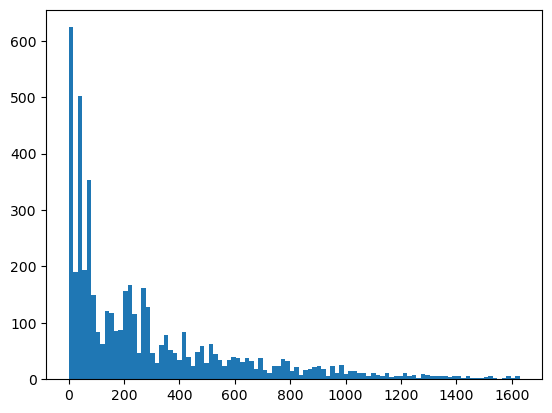

In [4]:
plt.hist(np.array(trainY[:5000]),bins=100)
plt.show()

Functions for training

In [3]:
def train(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for boards, sequences, lengths, labels in train_loader:
            count += 1
            boards, sequences, lengths, labels = boards.to(device, non_blocking=True), sequences.to(device, non_blocking=True), lengths, labels.to(device, non_blocking=True)
            # Forward Pass
            output = model(boards, sequences, lengths)
            loss = criterion(output, labels)
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                validation_loss = 0

                for boards, sequences, lengths, labels in val_loader:
                    boards, sequences, lengths, labels = boards.to(device, non_blocking=True), sequences.to(device, non_blocking=True), lengths, labels.to(device, non_blocking=True)
                    outputs = model(boards, sequences, lengths)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                val_loss_values.append(validation_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)

        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        if epoch <= 10:
            for op_params in optimizer.param_groups:
                op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values

Now let's train

In [4]:
dataset = MultimodalDataset(trainX_sequences, trainX_boards, trainX_seqlengths, trainY)
# Calculate split sizes
total_size = len(dataset)

# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2887027


## Experiment 1 (CNN has 2 Convolutions)

In [16]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

589


In [17]:
# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 72
d_embed = 32
NUM_EPOCHS = 25
d_out = len(vocab.id_to_move.keys())
model = MultiModal(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.7 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

/home/nathaniel/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


490555


Epoch 1, Training Loss: 6.682768297195435, Validation Error: 91.66666666666667, Validation Top-3 Accuracy: 8.33333358168602, Training Error: 98.64176570458405
Epoch 2, Training Loss: 5.682501029968262, Validation Error: 91.66666666666667, Validation Top-3 Accuracy: 8.33333358168602, Training Error: 94.90662139219015
Epoch 3, Training Loss: 4.880701231956482, Validation Error: 87.5, Validation Top-3 Accuracy: 16.66666716337204, Training Error: 92.69949066213923
Epoch 4, Training Loss: 4.429151296615601, Validation Error: 91.66666666666667, Validation Top-3 Accuracy: 16.66666716337204, Training Error: 89.64346349745331
Epoch 5, Training Loss: 4.106862878799438, Validation Error: 87.5, Validation Top-3 Accuracy: 16.66666716337204, Training Error: 84.04074702886248
Epoch 6, Training Loss: 3.8884287595748903, Validation Error: 87.5, Validation Top-3 Accuracy: 16.66666716337204, Training Error: 83.02207130730051
Epoch 7, Training Loss: 3.7301934957504272, Validation Error: 87.5, Validation T

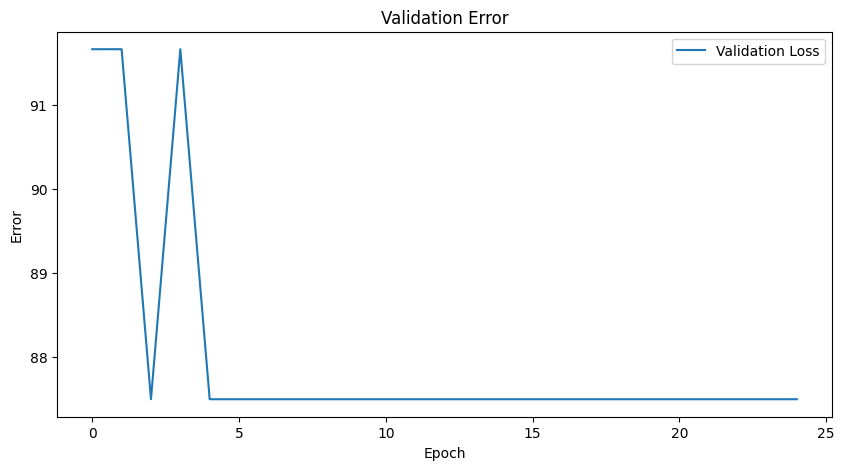

<Figure size 640x480 with 0 Axes>

In [18]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

What happens if we filter out illegal moves in our prediction?

In [63]:

val_size = int(total_size * 0.04)
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for boards, sequences, lengths, labels in val_loader:
            boards, sequences, lengths, labels = boards.to(device), sequences.to(device), lengths.to(device), labels.to(device)
            outputs = model(boards, sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                # This tells us we're looking at games that include the opening but has developed more than the first 4 half-moves
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    # print(predicted_move)
                    chess_board = load_board_state_from_san(sequence, vocab)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            # print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    # print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")


hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey


In [64]:
torch.save(model.state_dict(), 'multimodalmodel.pth')

## Experiment 2 (CNN has 3 convolutions,SE, ReLu after combining inputs and larger RNN)

In [67]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

1634630


In [77]:
# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 100
d_embed = 48
NUM_EPOCHS = 15
d_out = len(vocab.id_to_move.keys())
model = MultiModalTwo(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.72 # This causes the LR to be 5e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1131882


Epoch 1, Batch: 1000| Training Loss: 5.358224760532379
Epoch 1, Batch: 2000| Training Loss: 5.12661018884182
Epoch 1, Batch: 3000| Training Loss: 4.984487212657928
Epoch 1, Batch: 4000| Training Loss: 4.880090206086636
Epoch 1, Batch: 5000| Training Loss: 4.78517461733818
Epoch 1, Batch: 6000| Training Loss: 4.7084750316937765
Epoch 1, Batch: 7000| Training Loss: 4.644520375422069
Epoch 1, Batch: 8000| Training Loss: 4.584236370325089
Epoch 1, Batch: 9000| Training Loss: 4.53359999956025
Epoch 1, Batch: 10000| Training Loss: 4.487822722411155
Epoch 1, Batch: 11000| Training Loss: 4.445587667400186
Epoch 1, Batch: 12000| Training Loss: 4.40721798068285
Epoch 1, Batch: 13000| Training Loss: 4.372255387526292
Epoch 1, Batch: 14000| Training Loss: 4.34038493510655
Epoch 1, Batch: 15000| Training Loss: 4.310646494738261
Epoch 1, Batch: 16000| Training Loss: 4.282993175700307
Epoch 1, Batch: 17000| Training Loss: 4.257371399865431
Epoch 1, Batch: 18000| Training Loss: 4.234443660351965
Epoch

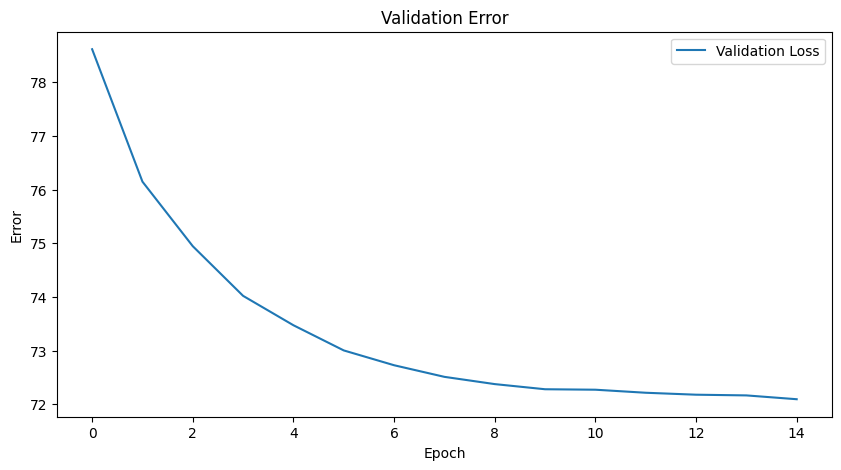

<Figure size 640x480 with 0 Axes>

In [78]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

In [79]:
def is_legal_move(chess_board, move_san):
    try:
        chess_move = chess_board.parse_san(move_san)
        return chess_move in chess_board.legal_moves
    except ValueError:
        # This handles cases where the SAN move cannot be parsed or is not legal
        return False

def load_board_state_from_san(moves):
    board = chess.Board()
    for index in moves:
        try:
            if index == 0:
                return board
            else:
                move_san = vocab.get_move(index.item())
                move = board.parse_san(move_san)
                board.push(move)
        except ValueError:
            # Handle invalid moves, e.g., break the loop or log an error
            break
    return board

val_size = int(total_size * 0.04)
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for boards, sequences, lengths, labels in val_loader:
            boards, sequences, lengths, labels = boards.to(device), sequences.to(device), lengths.to(device), labels.to(device)
            outputs = model(boards, sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                # This tells us we're looking at games that include the opening but has developed more than the first 4 half-moves
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    # print(predicted_move)
                    chess_board = load_board_state_from_san(sequence)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            # print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    # print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")

Validation Accuracy: 37.41142857142857%


In [80]:
torch.save(model.state_dict(), 'multimodalmodel-2.pth')

## Experiment 3 (focal loss)

In [86]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # alpha can be set to a constant, or it can be a tensor of shape (num_classes,)
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 100
d_embed = 48
NUM_EPOCHS = 15
d_out = len(vocab.id_to_move.keys())
model = MultiModalTwo(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = FocalLoss(gamma=2, alpha=1, reduction='mean')
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.72 # This causes the LR to be 5e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1131882


In [87]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 5.216632953643799
Epoch 1, Batch: 2000| Training Loss: 4.9681913522481915
Epoch 1, Batch: 3000| Training Loss: 4.809984962622325
Epoch 1, Batch: 4000| Training Loss: 4.693838460147381
Epoch 1, Batch: 5000| Training Loss: 4.583828910255432
Epoch 1, Batch: 6000| Training Loss: 4.49359255596002
Epoch 1, Batch: 7000| Training Loss: 4.419784398453576
Epoch 1, Batch: 8000| Training Loss: 4.352040460258722
Epoch 1, Batch: 9000| Training Loss: 4.294694580793381
Epoch 1, Batch: 10000| Training Loss: 4.244223247122765
Epoch 1, Batch: 11000| Training Loss: 4.197138833761215
Epoch 1, Batch: 12000| Training Loss: 4.153256935497125
Epoch 1, Batch: 13000| Training Loss: 4.113717842560548
Epoch 1, Batch: 14000| Training Loss: 4.077679372889655
Epoch 1, Batch: 15000| Training Loss: 4.044189786974589
Epoch 1, Batch: 16000| Training Loss: 4.012455889597535
Epoch 1, Batch: 17000| Training Loss: 3.9834087364673616
Epoch 1, Batch: 18000| Training Loss: 3.956665287401941


## Experiment 4 (attention)

In [51]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # alpha can be set to a constant, or it can be a tensor of shape (num_classes,)
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 128
d_embed = 64
NUM_EPOCHS = 15
d_out = len(vocab.id_to_move.keys())
model = MultiModalThree(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = FocalLoss(gamma=2, alpha=1, reduction='mean')
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.72 # This causes the LR to be 5e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1274809


In [52]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 5.287326567173004
Epoch 1, Batch: 2000| Training Loss: 5.047864525914192
Epoch 1, Batch: 3000| Training Loss: 4.905219877481461
Epoch 1, Batch: 4000| Training Loss: 4.79524082493782
Epoch 1, Batch: 5000| Training Loss: 4.70671489186287
Epoch 1, Batch: 6000| Training Loss: 4.622613087058068
Epoch 1, Batch: 7000| Training Loss: 4.555860832350595
Epoch 1, Batch: 8000| Training Loss: 4.496502450019121
Epoch 1, Batch: 9000| Training Loss: 4.445127610709932
Epoch 1, Batch: 10000| Training Loss: 4.398497691917419


KeyboardInterrupt: 

## Experiment 5 
scaling experiment 3 more

In [10]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2887027


In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # alpha can be set to a constant, or it can be a tensor of shape (num_classes,)
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6,pin_memory=True)

# Initialize model, loss function, and optimizer
d_hidden = 256
d_embed = 64
NUM_EPOCHS = 20
d_out = len(vocab.id_to_move.keys())
model = MultiModalTwo(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = FocalLoss(gamma=2, alpha=1, reduction='mean')
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.72 # This causes the LR to be 5e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

2257737


Epoch 1, Batch: 1000| Training Loss: 4.8901955642700194
Epoch 1, Batch: 2000| Training Loss: 4.567499182343483
Epoch 1, Batch: 3000| Training Loss: 4.370153081734975
Epoch 1, Batch: 4000| Training Loss: 4.225781790912151
Epoch 1, Batch: 5000| Training Loss: 4.115331648445129
Epoch 1, Batch: 6000| Training Loss: 4.026681294282278
Epoch 1, Batch: 7000| Training Loss: 3.9509704538413457
Epoch 1, Batch: 8000| Training Loss: 3.886772244900465
Epoch 1, Batch: 9000| Training Loss: 3.830372013224496
Epoch 1, Batch: 10000| Training Loss: 3.78042985496521
Epoch 1, Batch: 11000| Training Loss: 3.73538499064879
Epoch 1, Batch: 12000| Training Loss: 3.694986932992935
Epoch 1, Batch: 13000| Training Loss: 3.658469080888308
Epoch 1, Batch: 14000| Training Loss: 3.6249415147134236
Epoch 1, Batch: 15000| Training Loss: 3.593752561632792
Epoch 1, Batch: 16000| Training Loss: 3.564824816510081
Epoch 1, Batch: 17000| Training Loss: 3.53814223948647
Epoch 1, Batch: 18000| Training Loss: 3.513119463377529
E

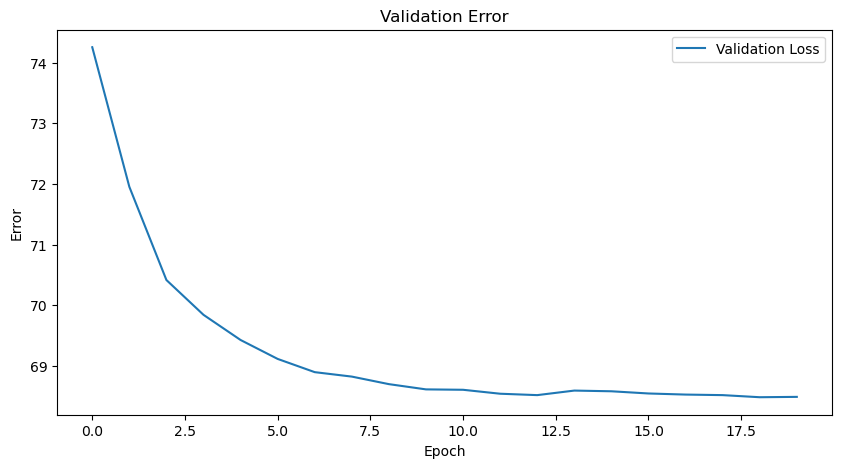

<Figure size 640x480 with 0 Axes>

In [12]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('multi-modal-jan-march-g5-feb-27.png')  # This will save the plot as an image

In [13]:
model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for boards, sequences, lengths, labels in val_loader:
            boards, sequences, lengths, labels = boards.to(device, non_blocking = True), sequences.to(device, non_blocking = True), lengths, labels.to(device, non_blocking = True)
            outputs = model(boards, sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                # This tells us we're looking at games that include the opening but has developed more than the first 4 half-moves
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    # print(predicted_move)
                    chess_board = load_board_state_from_san(sequence, vocab)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            # print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    # print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")

Validation Accuracy: 43.77431906614786%


In [23]:
torch.save(model.state_dict(), 'multimodalmodel-best.pth')

In [53]:
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# show_maps_on_training_data(vocab, model, train_loader, conv2 = False, multimodal= True)

torch.Size([1, 8121])
O-O-O
O-O-O
torch.Size([1, 12, 8, 8, 1])
torch.Size([1, 16, 1, 1, 1])
torch.Size([1, 1, 1, 1, 1])


RuntimeError: Sizes of tensors must match except in dimension 4. Expected size 12 but got size 16 for tensor number 1 in the list.

## Experiment 6 
SENetTwo baby -- hm it's not that promising... let's go back to this

In [6]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2887027


In [15]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # alpha can be set to a constant, or it can be a tensor of shape (num_classes,)
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6,pin_memory=True)

# Initialize model, loss function, and optimizer
d_hidden = 192
d_embed = 72
NUM_EPOCHS = 10
d_out = len(vocab.id_to_move.keys())
model = MultiModalFour(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = FocalLoss(gamma=2, alpha=1, reduction='mean')
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.72 # This causes the LR to be 5e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

2159953


In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('multi-modal-jan-march-g5-feb-27.png')  # This will save the plot as an image

## Experiment 7
let's scale the RNN baby

In [6]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2887027


In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # alpha can be set to a constant, or it can be a tensor of shape (num_classes,)
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6,pin_memory=True)

# Initialize model, loss function, and optimizer
d_hidden = 256
d_embed = 64
NUM_EPOCHS = 20
d_out = len(vocab.id_to_move.keys())
model = MultiModalFive(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = FocalLoss(gamma=2, alpha=1, reduction='mean')
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.72 # This causes the LR to be 5e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

4381497


Epoch 1, Batch: 1000| Training Loss: 4.75900833439827
Epoch 1, Batch: 2000| Training Loss: 4.388382541537285
Epoch 1, Batch: 3000| Training Loss: 4.1606564864317575
Epoch 1, Batch: 4000| Training Loss: 4.006464679956436
Epoch 1, Batch: 5000| Training Loss: 3.886658103322983
Epoch 1, Batch: 6000| Training Loss: 3.7896334119240445
Epoch 1, Batch: 7000| Training Loss: 3.709531047446387
Epoch 1, Batch: 8000| Training Loss: 3.6415253961980345
Epoch 1, Batch: 9000| Training Loss: 3.580289804061254
Epoch 1, Batch: 10000| Training Loss: 3.526648753285408
Epoch 1, Batch: 11000| Training Loss: 3.478701816623861
Epoch 1, Batch: 12000| Training Loss: 3.4365540742476783
Epoch 1, Batch: 13000| Training Loss: 3.3983328068256378
Epoch 1, Batch: 14000| Training Loss: 3.362579758320536
Epoch 1, Batch: 15000| Training Loss: 3.330839539782206
Epoch 1, Batch: 16000| Training Loss: 3.3009322288632394
Epoch 1, Batch: 17000| Training Loss: 3.2732747440197887
Epoch 1, Batch: 18000| Training Loss: 3.24705731214

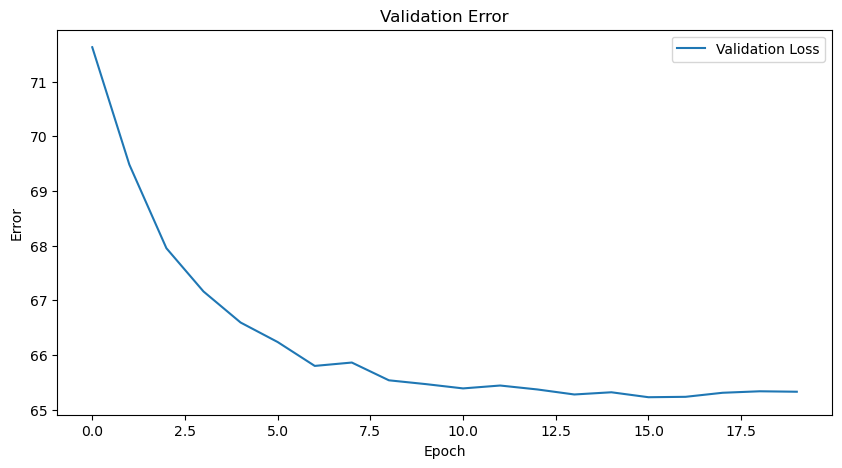

<Figure size 640x480 with 0 Axes>

In [8]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('multi-modal-jan-march-g5-feb-27.png')  # This will save the plot as an image

In [9]:
model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for boards, sequences, lengths, labels in val_loader:
            boards, sequences, lengths, labels = boards.to(device, non_blocking = True), sequences.to(device, non_blocking = True), lengths, labels.to(device, non_blocking = True)
            outputs = model(boards, sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                # This tells us we're looking at games that include the opening but has developed more than the first 4 half-moves
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    # print(predicted_move)
                    chess_board = load_board_state_from_san(sequence, vocab)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            # print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    # print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")

Validation Accuracy: 45.01369073353509%


## Experiment 8
let's scale all the way -- one more conv, dropout, and 256 from 128

In [26]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # alpha can be set to a constant, or it can be a tensor of shape (num_classes,)
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6,pin_memory=True)

# Initialize model, loss function, and optimizer
d_hidden = 256
d_embed = 64
NUM_EPOCHS = 13
d_out = len(vocab.id_to_move.keys())
model = MultiModalSeven(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = FocalLoss(gamma=2, alpha=1, reduction='mean')
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.72 # This causes the LR to be 5e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

7159417


Epoch 1, Batch: 1000| Training Loss: 4.882390671253204
Epoch 1, Batch: 2000| Training Loss: 4.525710904359817
Epoch 1, Batch: 3000| Training Loss: 4.320944158951441
Epoch 1, Batch: 4000| Training Loss: 4.184255250036716
Epoch 1, Batch: 5000| Training Loss: 4.076336099815369
Epoch 1, Batch: 6000| Training Loss: 3.9911560486157733
Epoch 1, Batch: 7000| Training Loss: 3.9208499415261406
Epoch 1, Batch: 8000| Training Loss: 3.8593906884789466
Epoch 1, Batch: 9000| Training Loss: 3.807422089126375
Epoch 1, Batch: 10000| Training Loss: 3.760690544271469
Epoch 1, Batch: 11000| Training Loss: 3.7182563562826676
Epoch 1, Batch: 12000| Training Loss: 3.680358818133672
Epoch 1, Batch: 13000| Training Loss: 3.645879002167628
Epoch 1, Batch: 14000| Training Loss: 3.6136590048074724
Epoch 1, Batch: 15000| Training Loss: 3.584489521741867
Epoch 1, Batch: 16000| Training Loss: 3.557563627690077
Epoch 1, Batch: 17000| Training Loss: 3.5325243727599873
Epoch 1, Batch: 18000| Training Loss: 3.50886912435

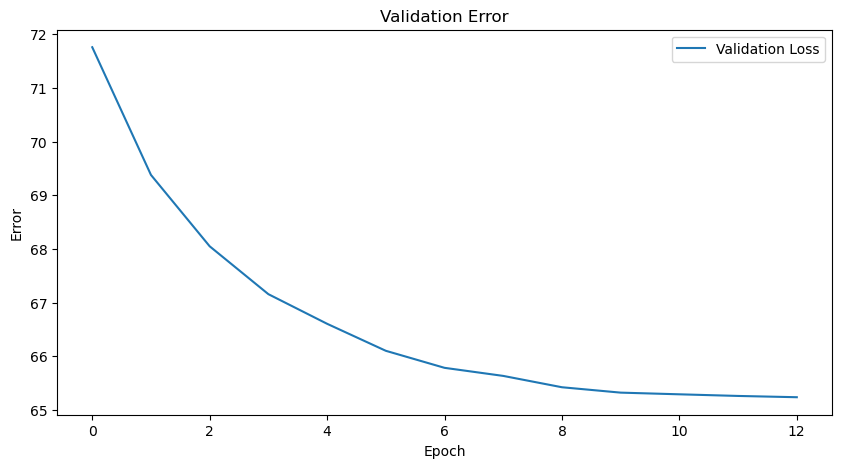

<Figure size 640x480 with 0 Axes>

In [27]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('multi-modal-big-jan-march-g5-march-1.png')  # This will save the plot as an image

In [28]:
model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for boards, sequences, lengths, labels in val_loader:
            boards, sequences, lengths, labels = boards.to(device, non_blocking = True), sequences.to(device, non_blocking = True), lengths, labels.to(device, non_blocking = True)
            outputs = model(boards, sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                # This tells us we're looking at games that include the opening but has developed more than the first 4 half-moves
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    # print(predicted_move)
                    chess_board = load_board_state_from_san(sequence, vocab)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            # print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    # print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")

Validation Accuracy: 45.38838449344286%
